In [109]:
# Cell 1: Setup Utility Scripts
import sys

# !!! THAY ĐỔI ĐƯỜNG DẪN NÀY !!!
# Trỏ đến dataset chứa file rtfm_model.py và rtfm_dataset.py
KAGGLE_DS_UTILITY_SCRIPTS = "/kaggle/input/rtfm-utility-scripts" 

# Thêm thư mục này vào Python path để có thể import
sys.path.append(KAGGLE_DS_UTILITY_SCRIPTS)

print(f"Đã thêm {KAGGLE_DS_UTILITY_SCRIPTS} vào sys.path")

Đã thêm /kaggle/input/rtfm-utility-scripts vào sys.path


In [110]:
# Cell 2: Imports
import torch
import numpy as np
import os
import cv2 # Để đọc video
from pathlib import Path # Xử lý đường dẫn
from sklearn.metrics import roc_auc_score # Tính AUC
from torch.utils.data import Dataset, DataLoader # Sẽ định nghĩa Dataset ở cell sau
from scipy.interpolate import interp1d # Để nội suy (upsample)
from tqdm.auto import tqdm # Thanh tiến trình
import sys

# Import từ file .py (nhờ Cell 1)
try:
    from rtfm_model import RTFM_TFM, Classifier
    print("Import 'rtfm_model' thành công.")
except ImportError:
    print("LỖI: Không thể import 'rtfm_model'.")
    print("Hãy kiểm tra lại đường dẫn KAGGLE_DS_UTILITY_SCRIPTS ở Cell 1.")
    
print("Import thư viện hoàn tất.")

Import 'rtfm_model' thành công.
Import thư viện hoàn tất.


In [111]:
# Cell 3: (QUAN TRỌNG NHẤT) Cấu hình đường dẫn Kaggle

# --- 1. SỬA TÊN DATASET CỦA BẠN ---
# Dataset chứa: rtfm_test.list, ..._model.pth, ...Annotation.txt
KAGGLE_DS_CONFIG = "/kaggle/input/rtfm-config-and-models"
# Dataset chứa: thư mục I3D_Features_10crop (chứa file .npy)
KAGGLE_DS_FEATURES = "/kaggle/input/i3d-features"
# Dataset chứa: thư mục RawVideo (chứa file .mp4)
KAGGLE_DS_VIDEOS = "/kaggle/input/rawvideo"

# --- 2. CẤU HÌNH PATH CHI TIẾT ---
# (Phần này sẽ tự động cập nhật dựa trên tên dataset ở trên)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Path đến các file config và model
TEST_LIST = Path(KAGGLE_DS_CONFIG) / "rtfm_test.list"
TFM_MODEL_PATH = "/kaggle/input/model-v2/rtfm_tfm_model.pth"
CLASSIFIER_MODEL_PATH = "/kaggle/input/model-v2/rtfm_multiclass_model.pth"
ANNOTATION_FILE = Path(KAGGLE_DS_CONFIG) / "Temporal_Anomaly_Annotation.txt"

# Path đến THƯ MỤC GỐC của features và videos
# !!! Sửa "I3D_Features_10crop" và "RawVideo" nếu tên thư mục của bạn khác !!!
FEATURE_ROOT = Path(KAGGLE_DS_FEATURES) / "I3D_Features"
VIDEO_ROOT = Path(KAGGLE_DS_VIDEOS) / "RawVideo"


print(f"Sử dụng thiết bị: {device}")
print(f"Test List: {TEST_LIST}")
print(f"Feature Root: {FEATURE_ROOT}")
print(f"Video Root: {VIDEO_ROOT}")

# Kiểm tra
if not TEST_LIST.exists(): print(f"CẢNH BÁO: Không tìm thấy Test List!")
if not FEATURE_ROOT.exists(): print(f"CẢNH BÁO: Không tìm thấy Feature Root!")
if not VIDEO_ROOT.exists(): print(f"CẢNH BÁO: Không tìm thấy Video Root!")

Sử dụng thiết bị: cpu
Test List: /kaggle/input/rtfm-config-and-models/rtfm_test.list
Feature Root: /kaggle/input/i3d-features/I3D_Features
Video Root: /kaggle/input/rawvideo/RawVideo


In [112]:
# Cell 4: (SỬA LỖI WINDOWS PATH) Định nghĩa Dataset riêng cho Kaggle
import os

class KaggleRTFMDataset(Dataset):
    def __init__(self, list_file, feature_root):
        self.feature_root = Path(feature_root)
        self.relative_paths = [] 
        self.labels = []
        
        print(f"Đang đọc list file từ: {list_file}")
        with open(list_file, 'r') as f:
            for line in f:
                try:
                    # Tách đường dẫn và nhãn
                    parts = line.strip().split()
                    raw_path = parts[0]
                    label = int(parts[1])
                    
                    # --- LOGIC SỬA LỖI WINDOWS PATH ---
                    # File list của bạn chứa: C:/Users/LHD/.../I3D_Features/Abuse/Abuse001.npy
                    # Chúng ta chỉ cần phần: Abuse/Abuse001.npy
                    
                    # Thay thế dấu gạch chéo ngược của Windows
                    clean_path = raw_path.replace('\\', '/')
                    
                    # Tìm từ khóa "I3D_Features" để cắt
                    keyword = "I3D_Features"
                    if keyword in clean_path:
                        # Lấy phần sau I3D_Features
                        # Ví dụ: .../I3D_Features/Abuse/Video.npy -> Abuse/Video.npy
                        rel_path = clean_path.split(keyword)[-1].strip('/')
                    else:
                        # Nếu không tìm thấy, lấy tên file cuối cùng (An toàn nhất)
                        rel_path = os.path.basename(clean_path)
                    
                    self.relative_paths.append(rel_path)
                    self.labels.append(label)
                    
                except Exception as e:
                    print(f"Bỏ qua dòng lỗi: {line.strip()} - Lỗi: {e}")
                    
        print(f"Tìm thấy {len(self.relative_paths)} mẫu trong list file.")
        # In thử 1 mẫu để kiểm tra
        if self.relative_paths:
            print(f"Mẫu đường dẫn sau khi sửa: {self.relative_paths[0]}")

    def __len__(self):
        return len(self.relative_paths)

    def __getitem__(self, idx):
        rel_path_str = self.relative_paths[idx]
        label = self.labels[idx]
        
        # Tạo đường dẫn .npy đầy đủ trên Kaggle
        full_npy_path = self.feature_root / rel_path_str
        
        try:
            features = np.load(full_npy_path)
        except Exception as e:
            # In lỗi chi tiết hơn để debug
            # print(f"Lỗi tải file: {full_npy_path}") 
            # Trả về dummy data để code không bị dừng (crash)
            features = np.zeros((32, 2048), dtype=np.float32)
            if features.ndim == 3: # Nếu lỡ dummy sai chiều
                 features = np.zeros((32, 10, 2048), dtype=np.float32)
        
        # Xử lý số clip (Logic cũ)
        num_clips = features.shape[0]
        target_clips = 32
        
        if num_clips > target_clips:
            indices = np.random.choice(num_clips, target_clips, replace=False)
            indices.sort()
            features = features[indices]
        elif num_clips < target_clips:
            indices = np.arange(num_clips)
            indices = np.tile(indices, (target_clips // num_clips) + 1)[:target_clips]
            indices.sort()
            features = features[indices]
        
        # Quan trọng: Trả về features, label, path, num_clips
        return torch.from_numpy(features).float(), torch.tensor(label).long(), rel_path_str, num_clips

print("Định nghĩa KaggleRTFMDataset (Đã fix lỗi path) hoàn tất.")

Định nghĩa KaggleRTFMDataset (Đã fix lỗi path) hoàn tất.


In [113]:
# Cell 5: Các Hàm Helper (ĐÃ FIX LỖI ĐỌC ANNOTATION)
import cv2
import numpy as np
from scipy.interpolate import interp1d

def load_annotations(annotation_path):
    annotations_map = {}
    print(f"Đang đọc file Annotation: {annotation_path}")
    
    with open(annotation_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line: continue
            
            parts = line.split()
            
            # parts[0]: Tên video (có .mp4)
            # parts[1]: Loại hành vi (Abuse, Normal...) -> BỎ QUA CÁI NÀY KHI LẤY TIME
            
            # Lấy key: Xóa đuôi .mp4 để khớp với tên file .npy
            video_name = parts[0].replace('.mp4', '')
            label_text = parts[1]
            
            frame_pairs = []
            
            # Nếu là Normal, không có sự kiện
            if 'Normal' in label_text or 'Normal' in video_name:
                annotations_map[video_name] = []
                continue
            
            # (QUAN TRỌNG) Bắt đầu vòng lặp từ index 2 (bỏ qua Tên và Label)
            # Dữ liệu từ index 2 trở đi là: start1 end1 start2 end2 ...
            try:
                for i in range(2, len(parts), 2):
                    start = int(parts[i])
                    end = int(parts[i+1])
                    
                    # UCF-Crime dùng -1 để đệm (padding), ta bỏ qua
                    if start != -1 and end != -1:
                        frame_pairs.append([start, end])
                        
                annotations_map[video_name] = frame_pairs
                
            except Exception as e:
                print(f"Lỗi xử lý dòng: {line} -> {e}")
                continue
                
    print(f"-> Đã tải Ground Truth cho {len(annotations_map)} video.")
    return annotations_map

def get_video_total_frames(video_path):
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened(): return 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return total_frames

def create_gt_vector(frame_pairs, total_frames):
    gt = np.zeros(total_frames, dtype=np.uint8)
    if not frame_pairs: return gt
        
    for start, end in frame_pairs:
        # Annotation gốc có thể là 1-based, ta chuyển về 0-based nếu cần
        # Nhưng thường giữ nguyên cũng không lệch nhiều
        start = max(0, start)
        end = min(total_frames - 1, end)
        
        if start <= end:
            gt[start:end+1] = 1
    return gt

def upsample_scores(scores_32, total_frames):
    # Nếu scores_32 rỗng hoặc video quá ngắn
    if len(scores_32) == 0: return np.zeros(total_frames)
    if total_frames == 0: return np.zeros(0)
        
    x_old = np.linspace(0, 1, len(scores_32))
    x_new = np.linspace(0, 1, total_frames)
    
    f = interp1d(x_old, scores_32, kind='linear', fill_value="extrapolate")
    return f(x_new)

print("Đã cập nhật hàm load_annotations chính xác.")

Đã cập nhật hàm load_annotations chính xác.


In [114]:
# Cell 6: Tải Model và Ground Truth (ĐÃ FIX LỖI CLASSIFIER CŨ)
import torch
import torch.nn as nn

# --- 1. ĐỊNH NGHĨA LẠI CLASSIFIER (Ghi đè phiên bản cũ) ---
# Việc này giúp tránh lỗi 'unexpected keyword argument num_classes'
class Classifier(nn.Module):
    def __init__(self, input_dim=2048, num_classes=14):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.6)
        
        self.fc2 = nn.Linear(512, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.6)
        
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        x = self.fc3(x)
        return x

# --- 2. Tải Model ---
print("Đang tải models...")
try:
    # Tải TFM (Dùng class gốc vẫn ổn)
    tfm_model = RTFM_TFM(input_dim=2048, num_layers=3).to(device)
    if TFM_MODEL_PATH.exists():
        tfm_model.load_state_dict(torch.load(TFM_MODEL_PATH, map_location=device))
        print("-> Đã tải TFM Model.")
    else:
        print("Cảnh báo: Không tìm thấy TFM checkpoint.")
    tfm_model.eval()

    # Tải Classifier (Dùng class vừa định nghĩa lại ở trên)
    try:
        print("-> Thử tải Classifier 14 lớp...")
        classifier_model = Classifier(input_dim=2048, num_classes=14).to(device)
        classifier_model.load_state_dict(torch.load(CLASSIFIER_MODEL_PATH, map_location=device))
        print("-> THÀNH CÔNG: Đã tải Classifier Multi-class (14 lớp).")
    except Exception as e1:
        print(f"-> Không khớp 14 lớp ({e1}). Đang thử tải Binary (1 lớp)...")
        try:
            # Thử lại với 1 class (dành cho model cũ binary)
            classifier_model = Classifier(input_dim=2048, num_classes=1).to(device)
            
            # (Mẹo) Load weights nhưng bỏ qua lớp cuối (fc3) nếu kích thước không khớp
            state_dict = torch.load(CLASSIFIER_MODEL_PATH, map_location=device)
            # Nếu model cũ dùng Sigmoid hoặc cấu trúc khác, việc load strict=False sẽ giúp tránh crash
            classifier_model.load_state_dict(state_dict, strict=False) 
            print("-> THÀNH CÔNG: Đã tải Classifier Binary (1 lớp) với chế độ strict=False.")
        except Exception as e2:
             print(f"-> Vẫn thất bại: {e2}")
             raise Exception("Không thể tải model nào khớp.")

    classifier_model.eval()
    print("Tất cả Model đã sẵn sàng.")
    
except Exception as e:
    print(f"LỖI CHUNG KHI TẢI MODEL: {e}")

# --- 3. Tải Ground Truth (Giữ nguyên vì đã chạy tốt) ---
# Chỉ cần đảm bảo biến annotations tồn tại
if 'annotations' not in globals() or not annotations:
    print("Cảnh báo: Biến annotations chưa có hoặc rỗng. Đang thử tải lại...")
    try:
        annotations = load_annotations(ANNOTATION_FILE)
    except:
        print("Không thể tải lại annotations.")

Đang tải models...
LỖI CHUNG KHI TẢI MODEL: 'str' object has no attribute 'exists'


In [115]:
# Cell 7: Tải Data Test (Sử dụng Dataset mới)

try:
    test_dataset = KaggleRTFMDataset(TEST_LIST, FEATURE_ROOT)
    # Batch size BẮT BUỘC là 1
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    print(f"Tải {len(test_dataset)} video test.")
except Exception as e:
    print(f"LỖI khi tải test dataset: {e}")

Đang đọc list file từ: /kaggle/input/rtfm-config-and-models/rtfm_test.list
Tìm thấy 109 mẫu trong list file.
Mẫu đường dẫn sau khi sửa: Normal_Videos_886_x264.npy
Tải 109 video test.


In [116]:
# Cell 8: Vòng lặp Đánh giá (Tự động tìm trong các thư mục con Abuse, Arrest...)
import glob

print("--- BẮT ĐẦU ĐÁNH GIÁ ---")

# === BƯỚC 1: TẠO BẢN ĐỒ VIDEO (Mapping) ===
print(f"Đang quét tìm toàn bộ video trong: {VIDEO_ROOT}")
print("(Quá trình này sẽ tìm trong các thư mục con: Abuse, Arrest, Normal...)")

video_path_map = {}
# rglob sẽ tìm đệ quy tất cả file .mp4
found_videos = list(VIDEO_ROOT.rglob("*.mp4"))

for vid_path in found_videos:
    # Lưu key là tên file không đuôi
    # Ví dụ: /.../Abuse/Abuse001_x264.mp4 -> Key: Abuse001_x264
    video_key = vid_path.stem 
    video_path_map[video_key] = vid_path

print(f"-> Đã lập bản đồ vị trí cho {len(video_path_map)} video.")

# In thử vài ví dụ để kiểm tra
if len(video_path_map) > 0:
    print("Ví dụ 3 video đầu tiên tìm thấy:")
    for k in list(video_path_map.keys())[:3]:
        print(f" - {k}: {video_path_map[k]}")
else:
    print("⚠️ LỖI NGHIÊM TRỌNG: Không tìm thấy video nào! Kiểm tra lại tên thư mục RawVideo.")

# === BƯỚC 2: VÒNG LẶP ĐÁNH GIÁ ===
all_scores_flat = []
all_gt_flat = []

# Tạo danh sách lỗi để báo cáo sau
missing_videos = []

progress_bar = tqdm(test_loader, desc="Đánh giá")

with torch.no_grad():
    for features, label, relative_path_list, num_clips_tensor in progress_bar:
        
        relative_path_str = relative_path_list[0]
        # Lấy tên video key từ file npy (ví dụ Abuse001_x264)
        video_name_key = Path(relative_path_str).stem
        
        features = features.to(device)
        if features.dim() == 4: features = torch.mean(features, dim=2)

        # --- Map Video Path ---
        if video_name_key not in video_path_map:
            # Thử logic dự phòng: Đôi khi tên file lệch nhau chữ "_x264"
            if video_name_key + "_x264" in video_path_map:
                video_name_key = video_name_key + "_x264"
            elif video_name_key.replace("_x264", "") in video_path_map:
                video_name_key = video_name_key.replace("_x264", "")
            else:
                if video_name_key not in missing_videos:
                    print(f"Không tìm thấy video gốc: {video_name_key}")
                    missing_videos.append(video_name_key)
                continue
                
        video_path = video_path_map[video_name_key]
        
        try:
            # Lấy tổng số frame
            total_frames = get_video_total_frames(video_path)
            if total_frames == 0: continue
            
            # Lấy ground truth
            if video_name_key not in annotations:
                 # Code fix tên trong annotation nếu cần
                 continue
                 
            gt_frame_pairs = annotations[video_name_key]
            gt_frames_vector = create_gt_vector(gt_frame_pairs, total_frames)
            
            # Chạy Model
            robust_features = tfm_model(features) 
            robust_features_flat = robust_features.reshape(-1, 2048) 
            predictions = classifier_model(robust_features_flat) 
            
            scores = predictions.cpu().numpy()
            
            # Xử lý Binary vs Multi-class output
            if scores.shape[1] > 1: # Multi-class
                import torch.nn.functional as F_torch
                probs = F_torch.softmax(predictions, dim=1)
                # Score bất thường = 1 - Score lớp Normal (lớp 0)
                anomaly_scores = 1.0 - probs[:, 0] 
                scores_32 = anomaly_scores.cpu().numpy()
            else: # Binary
                scores_32 = scores.squeeze()
            
            # Upsample
            frame_scores = upsample_scores(scores_32, total_frames)
            
            all_scores_flat.append(frame_scores)
            all_gt_flat.append(gt_frames_vector)
            
        except Exception as e:
            print(f"Lỗi xử lý {video_name_key}: {e}")
            continue

print("--- Đánh giá hoàn tất ---")
if missing_videos:
    print(f"Tổng cộng {len(missing_videos)} video bị thiếu file gốc.")

--- BẮT ĐẦU ĐÁNH GIÁ ---
Đang quét tìm toàn bộ video trong: /kaggle/input/rawvideo/RawVideo
(Quá trình này sẽ tìm trong các thư mục con: Abuse, Arrest, Normal...)
-> Đã lập bản đồ vị trí cho 1900 video.
Ví dụ 3 video đầu tiên tìm thấy:
 - RoadAccidents111_x264: /kaggle/input/rawvideo/RawVideo/RoadAccidents/RoadAccidents111_x264.mp4
 - RoadAccidents009_x264: /kaggle/input/rawvideo/RawVideo/RoadAccidents/RoadAccidents009_x264.mp4
 - RoadAccidents033_x264: /kaggle/input/rawvideo/RawVideo/RoadAccidents/RoadAccidents033_x264.mp4


Đánh giá:   0%|          | 0/109 [00:00<?, ?it/s]

--- Đánh giá hoàn tất ---


In [117]:
# Cell 9: Tính và In AUC

if not all_scores_flat:
    print("LỖI: Không có video nào được xử lý. Không thể tính AUC.")
else:
    # Gộp kết quả từ tất cả video lại
    final_scores = np.concatenate(all_scores_flat)
    final_gt = np.concatenate(all_gt_flat)

    print(f"Tổng số frame được đánh giá: {len(final_scores)}")
    
    # Tính AUC
    auc = roc_auc_score(final_gt, final_scores)

    print("\n" + "="*30)
    print(f"--- HOÀN TẤT ĐÁNH GIÁ ---")
    print(f"Frame-level ROC AUC: {auc * 100:.2f}%")
    print("="*30)

Tổng số frame được đánh giá: 172718

--- HOÀN TẤT ĐÁNH GIÁ ---
Frame-level ROC AUC: 60.78%


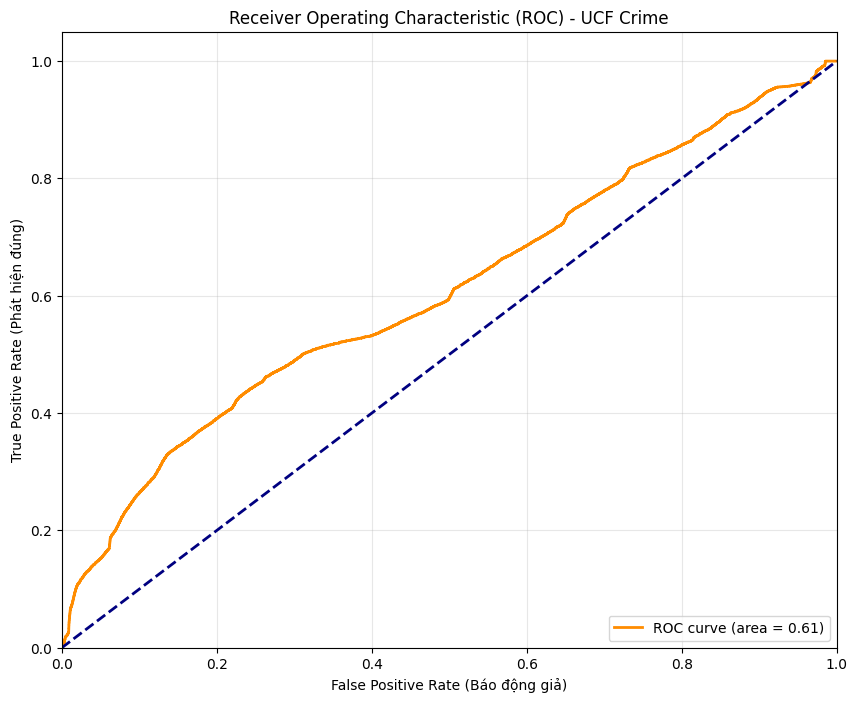

In [118]:
# Cell 10: Vẽ đường cong ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Tính toán các điểm cho đường cong ROC
fpr, tpr, thresholds = roc_curve(final_gt, final_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Đường ngẫu nhiên
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Báo động giả)')
plt.ylabel('True Positive Rate (Phát hiện đúng)')
plt.title('Receiver Operating Characteristic (ROC) - UCF Crime')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()